# Imports

In [1]:
import os
import re
import nltk
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/storm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/storm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/storm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preaparing Data

## Reading

### Gun violance

In [3]:
gun_context_spam = pd.read_csv('dataset/gun-violence/context-spam/published_data_spam-MLJ-2022_gun-violence_context-spam_context_spam_5000_no_link.csv')
gun_not_context_spam = pd.read_csv('dataset/gun-violence/context-spam/published_data_spam-MLJ-2022_gun-violence_context-spam_not_context_spam_5000_no_link.csv')
gun_context_spam.drop(['tweet_id'], axis=1, inplace=True)
gun_not_context_spam.drop(['tweet_id'], axis=1, inplace=True)
gun = pd.concat([gun_context_spam, gun_not_context_spam])
gun.reset_index(drop=True, inplace=True)

In [4]:
gun

,text,label
0,Stack-On PDS-1500 Gun Safe <em>URL01 Removed</...,1
1,#protection #safe Buy Now and be Safe <em>URL0...,1
2,I'm in the running to win the PolyCase - CZ P-...,1
3,"ZEV Technologies Prizefighter, a cheap Agency ...",1
4,I'm in the running to win a Springfield 1911 P...,1
...,...,...
4995,"Sai Baba! Sai Buhari! ""Dead men are getting ap...",0
4996,Alpha Krav Maga CT Pistol retention while firi...,0
4997,@USER01 “Uhm...Well...I’ll just be straightfor...,0
4998,The 2nd Amendment states it it PLAIN LANGUAGE ...,0


### MeToo

In [5]:
metoo_context_spam = pd.read_csv('dataset/metoo/context-spam/published_data_spam-MLJ-2022_metoo_context-spam_context_spam_5000_no_link.csv')
metoo_not_context_spam = pd.read_csv('dataset/metoo/context-spam/published_data_spam-MLJ-2022_metoo_context-spam_not_context_spam_5000_no_link.csv')
metoo_context_spam.drop(['tweet_id'], axis=1, inplace=True)
metoo_not_context_spam.drop(['tweet_id'], axis=1, inplace=True)
metoo = pd.concat([metoo_context_spam, metoo_not_context_spam])
metoo.reset_index(drop=True, inplace=True)

In [6]:
metoo

,text,label
0,Check out the latest happening in #events. #Ev...,1
1,"Will b at #Half-PriceBooks, 15146 5/12: book s...",1
2,Thursday at 12 noon CT URL01_Removed recaps 5 ...,1
3,Move To #LosAngeles - Come #Glow Up And Be A S...,1
4,Men's Sweater Hoodie Fashion Casual Slim Ch......,1
...,...,...
4995,This started when i was 6. A elderly man who h...,0
4996,Meet the woman who started #MeToo 10 years ago...,0
4997,@USER01 @USER02 @USER03 @USER04 #MeToo and no ...,0
4998,@USER01 @USER02 Correct. But she’s not talking...,0


### Parenting

In [7]:
parenting_context_spam = pd.read_csv('dataset/parenting/context-spam/published_data_spam-MLJ-2022_parenting_context-spam_context_spam_5000_no_link.csv')
parenting_not_context_spam = pd.read_csv('dataset/parenting/context-spam/published_data_spam-MLJ-2022_parenting_context-spam_not_context_spam_5000_no_link.csv')
parenting_context_spam.drop(['tweet_id'], axis=1, inplace=True)
parenting_not_context_spam.drop(['tweet_id'], axis=1, inplace=True)
parenting = pd.concat([parenting_context_spam, parenting_not_context_spam])
parenting.reset_index(drop=True, inplace=True)

In [8]:
parenting

,text,label
0,Pura Stainless Drinking Bottles Bundle Prizepa...,1
1,LG’s Twin Wash System @USER02 Is Everything Yo...,1
2,#AD #GetActiveAtWalmart Enter to #win some awe...,1
3,@USER01 tweet me when your hosting these givea...,1
4,Giveaway! Three Winners! Scribblenauts™ Showdo...,1
...,...,...
4995,@USER01 We sure can! Give us a quick call when...,0
4996,This Windex ad about kids growing up is making...,0
4997,Tips for surviving Daylight Savings Time - <em...,0
4998,The Lane Bryant ad the networks didn't want yo...,0


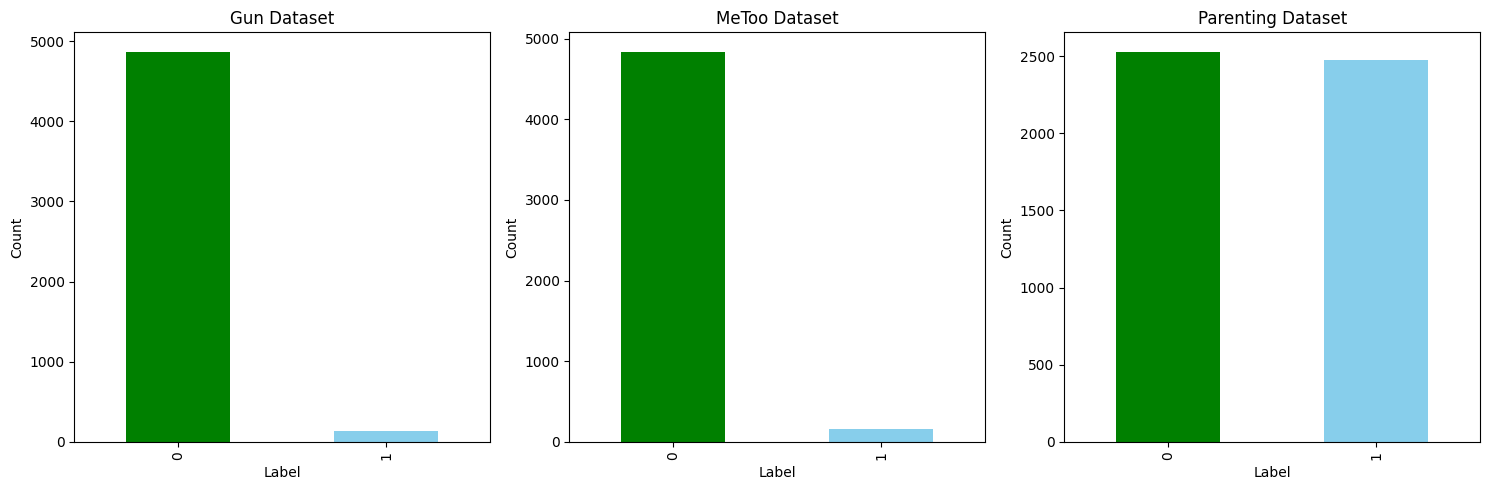

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

gun_labels = gun['label'].value_counts()
gun_labels.plot(kind='bar', ax=axs[0], color=['green', 'skyblue'])
axs[0].set_title('Gun Dataset')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

metoo_labels = metoo['label'].value_counts()
metoo_labels.plot(kind='bar', ax=axs[1], color=['green', 'skyblue'])
axs[1].set_title('MeToo Dataset')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

parenting_labels = parenting['label'].value_counts()
parenting_labels.plot(kind='bar', ax=axs[2], color=['green', 'skyblue'])
axs[2].set_title('Parenting Dataset')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Cleaning

In [9]:
def clean_text(text):
    text = re.sub(r"@\w+", "", text)
    
    text = re.sub(r"<em>.*?</em>", "", text)
    
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    text = re.sub(r"[^\w\s]", "", text)
    
    text = re.sub(r"\d+", "", text)
    
    text = text.lower()
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    cleaned_text = " ".join(lemmatized_tokens)
    
    return cleaned_text

In [10]:
gun['text'] = gun['text'].apply(clean_text)
metoo['text'] = metoo['text'].apply(clean_text)
parenting['text'] = parenting['text'].apply(clean_text)

## Spliting

In [11]:
gun_train, gun_test = train_test_split(
    gun, test_size=0.1, random_state=42, stratify=gun['label'])
gun_train, gun_val = train_test_split(
    gun_train, test_size=0.1, random_state=42, stratify=gun_train['label'])

gun_train = pd.DataFrame(gun_train, columns=gun.columns)
gun_test = pd.DataFrame(gun_test, columns=gun.columns)
gun_val = pd.DataFrame(gun_val, columns=gun.columns)

metoo_train, metoo_test = train_test_split(
    metoo, test_size=0.1, random_state=42, stratify=metoo['label'])
metoo_train, metoo_val = train_test_split(
    metoo_train, test_size=0.1, random_state=42, stratify=metoo_train['label'])

metoo_train = pd.DataFrame(metoo_train, columns=metoo.columns)
metoo_test = pd.DataFrame(metoo_test, columns=metoo.columns)
metoo_val = pd.DataFrame(metoo_val, columns=metoo.columns)

parenting_train, parenting_test = train_test_split(
    parenting, test_size=0.1, random_state=42, stratify=parenting['label'])
parenting_train, parenting_val = train_test_split(
    parenting_train, test_size=0.1, random_state=42, stratify=parenting_train['label'])

parenting_train = pd.DataFrame(parenting_train, columns=parenting.columns)
parenting_test = pd.DataFrame(parenting_test, columns=parenting.columns)
parenting_val = pd.DataFrame(parenting_val, columns=parenting.columns)

gun_train.reset_index(drop=True, inplace=True)
gun_test.reset_index(drop=True, inplace=True)
gun_val.reset_index(drop=True, inplace=True)

metoo_train.reset_index(drop=True, inplace=True)
metoo_test.reset_index(drop=True, inplace=True)
metoo_val.reset_index(drop=True, inplace=True)

parenting_train.reset_index(drop=True, inplace=True)
parenting_test.reset_index(drop=True, inplace=True)
parenting_val.reset_index(drop=True, inplace=True)


# Feature Extraction

## Bag Of Words

In [12]:
vectorizer = CountVectorizer()

### Parenting

In [13]:
parenting_train_bow = vectorizer.fit_transform(parenting_train['text'])
parenting_test_bow = vectorizer.transform(parenting_test['text'])
parenting_train_bow = parenting_train_bow.toarray()
parenting_test_bow = parenting_test_bow.toarray()

### Gun

In [14]:
gun_train_bow = vectorizer.fit_transform(gun_train['text'])
gun_test_bow = vectorizer.transform(gun_test['text'])
gun_train_bow = gun_train_bow.toarray()
gun_test_bow = gun_test_bow.toarray()

### MeToo

In [15]:
metoo_train_bow = vectorizer.fit_transform(metoo_train['text'])
metoo_test_bow = vectorizer.transform(metoo_test['text'])
metoo_train_bow = metoo_train_bow.toarray()
metoo_test_bow = metoo_test_bow.toarray()

# Classic Algorithms

## Random Forest

In [16]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_macro')

### Parenting

In [17]:
grid_search.fit(parenting_train_bow, parenting_train['label'])

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
best_model = grid_search.best_estimator_

parenting_rf_pred = best_model.predict(parenting_test_bow)

Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


### Gun

In [18]:
grid_search.fit(gun_train_bow, gun_train['label'])

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
best_model = grid_search.best_estimator_

gun_rf_pred = best_model.predict(gun_test_bow)

Best Parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### MeToo

In [19]:
grid_search.fit(metoo_train_bow, metoo_train['label'])

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
best_model = grid_search.best_estimator_

metoo_rf_pred = best_model.predict(metoo_test_bow)

Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# Neural Network

## Model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [21]:
class MyModel(nn.Module):
    def __init__(self, bert_model):
        super(MyModel, self).__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.bert_model.config.hidden_size, 2)

    def forward(self, inputs):
        outputs = self.bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        bert_output = last_hidden_state[:, 0, :]
        dropout_output = self.dropout(bert_output)
        linear_output = self.linear(dropout_output)
        return linear_output

## Loading Data

In [22]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        return
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.loc[idx, 'text']
        label = self.df.loc[idx, 'label']
        tokenized = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        output = {
            'input_ids': tokenized['input_ids'].flatten(),
            'attention_mask': tokenized['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }
        return output

### Datasets

In [24]:
gun_train_dataset = CustomDataset(gun_train, bert_tokenizer)
gun_val_dataset = CustomDataset(gun_val, bert_tokenizer)
gun_test_dataset = CustomDataset(gun_test, bert_tokenizer)

metoo_train_dataset = CustomDataset(metoo_train, bert_tokenizer)
metoo_val_dataset = CustomDataset(metoo_val, bert_tokenizer)
metoo_test_dataset = CustomDataset(metoo_test, bert_tokenizer)

parenting_train_dataset = CustomDataset(parenting_train, bert_tokenizer)
parenting_val_dataset = CustomDataset(parenting_val, bert_tokenizer)
parenting_test_dataset = CustomDataset(parenting_test, bert_tokenizer)

### Data Loaders

In [25]:
batch_size = 22
num_epochs = 20

gun_train_dataloader = torch.utils.data.DataLoader(gun_train_dataset, batch_size=batch_size, shuffle=True)
gun_val_dataloader = torch.utils.data.DataLoader(gun_val_dataset, batch_size=batch_size, shuffle=True)
gun_test_dataloader = torch.utils.data.DataLoader(gun_test_dataset, batch_size=batch_size, shuffle=True)

metoo_train_dataloader = torch.utils.data.DataLoader(metoo_train_dataset, batch_size=batch_size, shuffle=True)
metoo_val_dataloader = torch.utils.data.DataLoader(metoo_val_dataset, batch_size=batch_size, shuffle=True)
metoo_test_dataloader = torch.utils.data.DataLoader(metoo_test_dataset, batch_size=batch_size, shuffle=True)

parenting_train_dataloader = torch.utils.data.DataLoader(parenting_train_dataset, batch_size=batch_size, shuffle=True)
parenting_val_dataloader = torch.utils.data.DataLoader(parenting_val_dataset, batch_size=batch_size, shuffle=True)
parenting_test_dataloader = torch.utils.data.DataLoader(parenting_test_dataset, batch_size=batch_size, shuffle=True)

## Learning

In [26]:
def train_model(bert_model, train_dataloader, validation_dataloader) -> MyModel:
    bert_model = bert_model.to(device)
    my_model = MyModel(bert_model)
    my_model = my_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(my_model.parameters(), lr=0.000005)

    best_accuracy = 0.0
    patience = 5
    counter = 0

    for epoch in range(20):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_dataloader:
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'label'}
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = my_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.shape[0]
            inputs = None
            labels = None
        torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Validation
        my_model.eval()
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for val_batch in validation_dataloader:
                val_inputs = {key: value.to(device) for key, value in val_batch.items() if key != 'label'}
                val_labels = val_batch['label'].to(device)

                val_outputs = my_model(val_inputs)
                val_probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
                val_predictions = torch.argmax(val_probabilities, dim=1)
                val_correct_predictions += (val_predictions == val_labels).sum().item()
                val_total_predictions += val_labels.shape[0]
                val_inputs = None
                val_labels = None
        torch.cuda.empty_cache()

        val_accuracy = val_correct_predictions / val_total_predictions
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break

        my_model.train()
    
    return my_model

### Parenting

In [27]:
model_file = 'models/parenting_model.pth'
parenting_bert_model = BertModel.from_pretrained('bert-base-uncased')

if os.path.isfile(model_file):
    parenting_model = MyModel(parenting_bert_model)
    parenting_model.load_state_dict(torch.load(model_file))
    parenting_model = parenting_model.to(device)
else:
    parenting_model = train_model(parenting_bert_model, parenting_train_dataloader, parenting_val_dataloader)
    torch.save(parenting_model.state_dict(), model_file)

### Gun

In [28]:
model_file = 'models/gun_model.pth'
gun_bert_model = BertModel.from_pretrained('bert-base-uncased')

if os.path.isfile(model_file):
    gun_model = MyModel(parenting_bert_model)
    gun_model.load_state_dict(torch.load(model_file))
    gun_model = gun_model.to(device)
else:
    gun_model = train_model(gun_bert_model, gun_train_dataloader, gun_val_dataloader)
    torch.save(gun_model.state_dict(), model_file)

### MeToo

In [29]:
model_file = 'models/metoo_model.pth'
metoo_bert_model = BertModel.from_pretrained('bert-base-uncased')

if os.path.isfile(model_file):
    metoo_model = MyModel(metoo_bert_model)
    metoo_model.load_state_dict(torch.load(model_file))
    metoo_model = metoo_model.to(device)
else:
    metoo_model= train_model(metoo_bert_model, metoo_train_dataloader, metoo_val_dataloader)
    torch.save(metoo_model.state_dict(), model_file)

# Testing

In [30]:
def report(test, pred):
    print("Classification Report:")
    print(classification_report(test, pred))
    cm = confusion_matrix(test, pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not spam', 'spam'])
    disp.plot()
    plt.show()

In [31]:
def test_model(my_model, test_dataloader):
    my_model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for test_batch in test_dataloader:
            test_inputs = {key: value.to(device) for key, value in test_batch.items() if key != 'label'}
            test_labels = test_batch['label'].to(device)

            test_outputs = my_model(test_inputs)
            test_probabilities = torch.nn.functional.softmax(test_outputs, dim=1)
            test_predictions = torch.argmax(test_probabilities, dim=1)

            true_labels.extend(test_labels.cpu().numpy())
            predicted_labels.extend(test_predictions.cpu().numpy())
            test_inputs = None
            test_labels = None
        torch.cuda.empty_cache()

    report(true_labels, predicted_labels)

## Within Domain

### Parenting

#### Neural Network

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.01      0.02       253
           1       0.49      0.99      0.66       247

    accuracy                           0.50       500
   macro avg       0.55      0.50      0.34       500
weighted avg       0.55      0.50      0.34       500



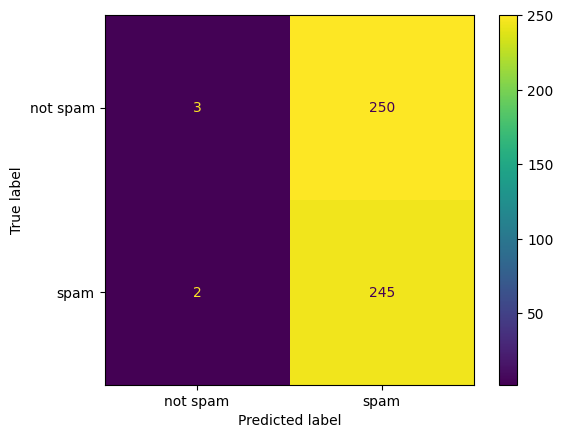

In [32]:
test_model(parenting_model, parenting_test_dataloader)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       253
           1       0.81      0.63      0.71       247

    accuracy                           0.74       500
   macro avg       0.76      0.74      0.74       500
weighted avg       0.76      0.74      0.74       500



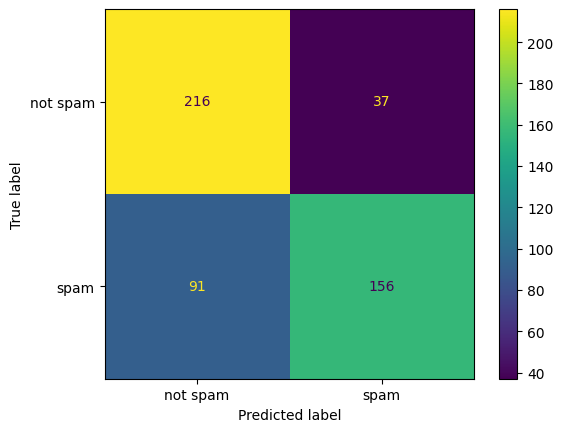

In [33]:
report(parenting_test['label'], parenting_rf_pred)

### Gun

#### Neural Network

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       487
           1       0.53      0.69      0.60        13

    accuracy                           0.98       500
   macro avg       0.76      0.84      0.79       500
weighted avg       0.98      0.98      0.98       500



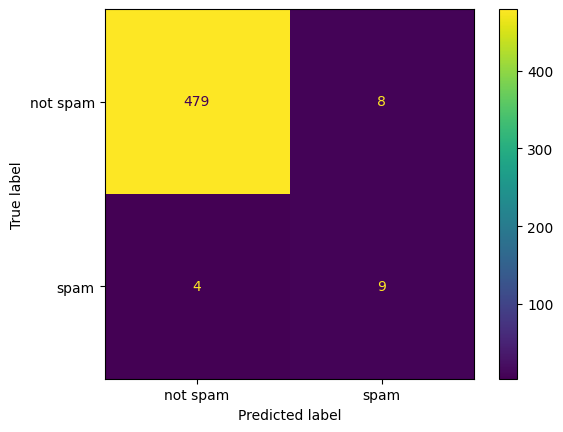

In [34]:
test_model(gun_model, gun_test_dataloader)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       487
           1       0.00      0.00      0.00        13

    accuracy                           0.97       500
   macro avg       0.49      0.50      0.49       500
weighted avg       0.95      0.97      0.96       500



/home/aref/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aref/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aref/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


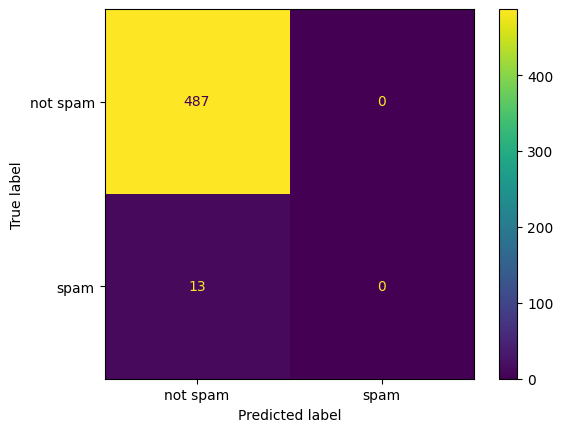

In [35]:
report(gun_test['label'], gun_rf_pred)

### MeToo

#### Neural Network

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       484
           1       0.76      0.81      0.79        16

    accuracy                           0.99       500
   macro avg       0.88      0.90      0.89       500
weighted avg       0.99      0.99      0.99       500



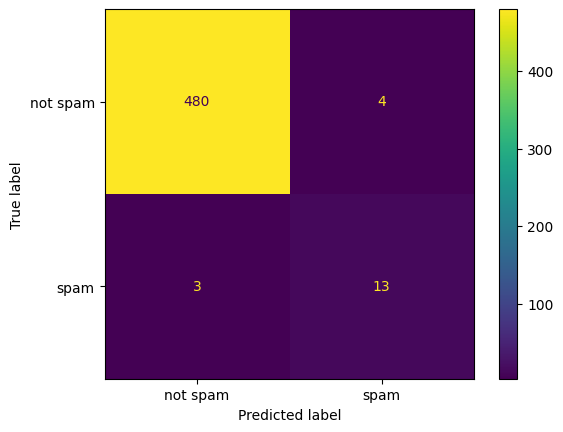

In [36]:
test_model(metoo_model, metoo_test_dataloader)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       484
           1       0.00      0.00      0.00        16

    accuracy                           0.97       500
   macro avg       0.48      0.50      0.49       500
weighted avg       0.94      0.97      0.95       500



/home/aref/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aref/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aref/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


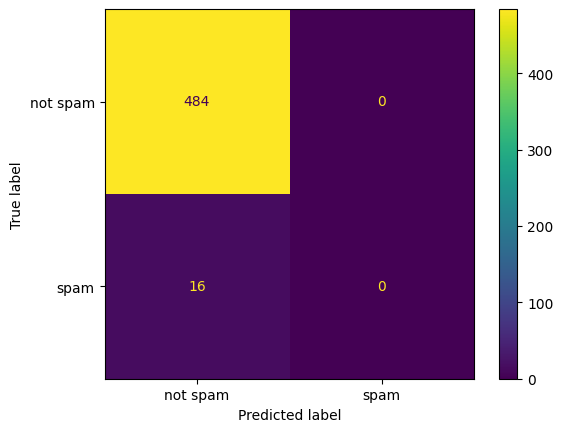

In [37]:
report(metoo_test['label'], metoo_rf_pred)

## Cross Domain

### Parenting Model

#### Gun Data

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.01      0.02       487
           1       0.02      0.85      0.04        13

    accuracy                           0.03       500
   macro avg       0.34      0.43      0.03       500
weighted avg       0.65      0.03      0.02       500



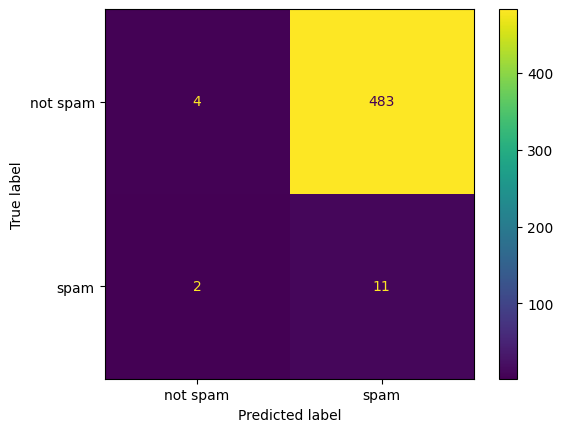

In [38]:
test_model(parenting_model, gun_test_dataloader)

#### MeToo Data

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       484
           1       0.03      0.94      0.06        16

    accuracy                           0.03       500
   macro avg       0.02      0.47      0.03       500
weighted avg       0.00      0.03      0.00       500



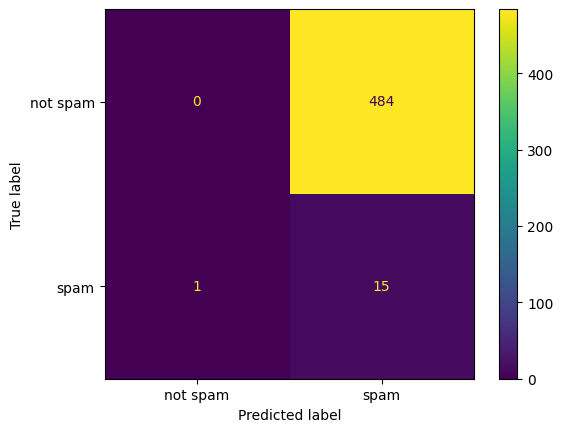

In [39]:
test_model(parenting_model, metoo_test_dataloader)

### Gun Model

#### Parenting Data

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.98      0.69       253
           1       0.89      0.13      0.22       247

    accuracy                           0.56       500
   macro avg       0.71      0.55      0.46       500
weighted avg       0.71      0.56      0.46       500



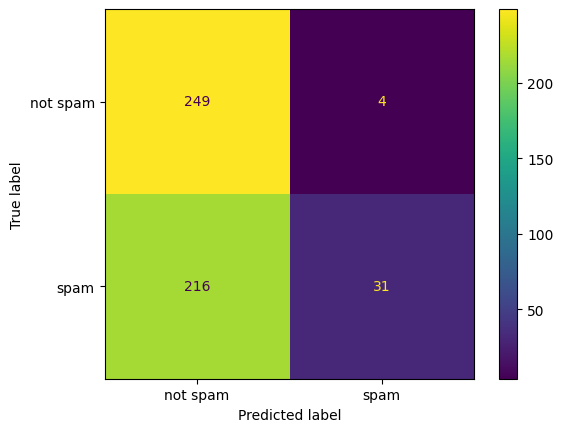

In [40]:
test_model(gun_model, parenting_test_dataloader)

#### MeToo Data

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       484
           1       0.00      0.00      0.00        16

    accuracy                           0.97       500
   macro avg       0.48      0.50      0.49       500
weighted avg       0.94      0.97      0.95       500



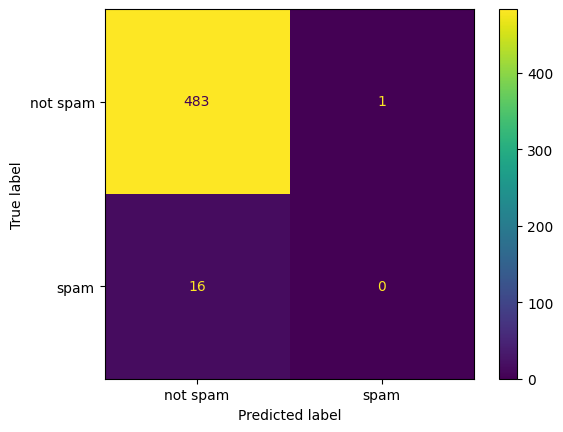

In [41]:
test_model(gun_model, metoo_test_dataloader)

### MeToo Model

#### Gun Data

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       487
           1       0.38      0.38      0.38        13

    accuracy                           0.97       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.97      0.97      0.97       500



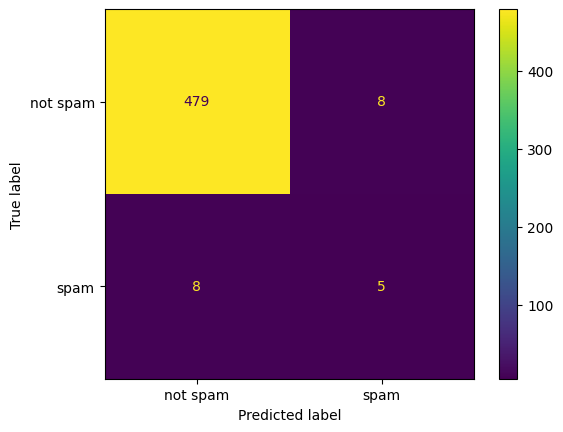

In [42]:
test_model(metoo_model, gun_test_dataloader)

#### Parenting Data

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.95      0.66       253
           1       0.54      0.06      0.11       247

    accuracy                           0.51       500
   macro avg       0.52      0.50      0.39       500
weighted avg       0.52      0.51      0.39       500



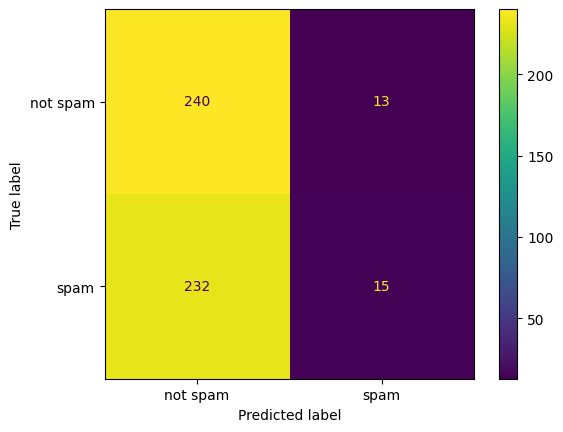

In [43]:
test_model(metoo_model, parenting_test_dataloader)